In [29]:
%matplotlib inline
import glob, re
import numpy as np
import pandas as pd
import xgboost
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
data = {
    'tra': pd.read_csv('data/air_visit_data.csv.zip', compression="zip"),
    'as': pd.read_csv('data/air_store_info.csv.zip', compression="zip"),
    'hs': pd.read_csv('data/hpg_store_info.csv.zip', compression="zip"),
    'ar': pd.read_csv('data/air_reserve.csv.zip', compression="zip"),
    'hr': pd.read_csv('data/hpg_reserve.csv.zip', compression="zip"),
    'id': pd.read_csv('data/store_id_relation.csv.zip', compression="zip"),
    'tes': pd.read_csv('data/sample_submission.csv.zip', compression="zip"),
    'hol': pd.read_csv('data/date_info.csv.zip', compression="zip").rename(columns={'calendar_date':'visit_date'})
    }

In [4]:
pdp.ProfileReport(data['ar'])

Number of variables,4
Number of observations,92378
Total Missing (%),0.0%
Total size in memory,2.8 MiB
Average record size in memory,32.0 B
Numeric,1
Categorical,3
Boolean,0
Date,0
Text (Unique),0
Rejected,0


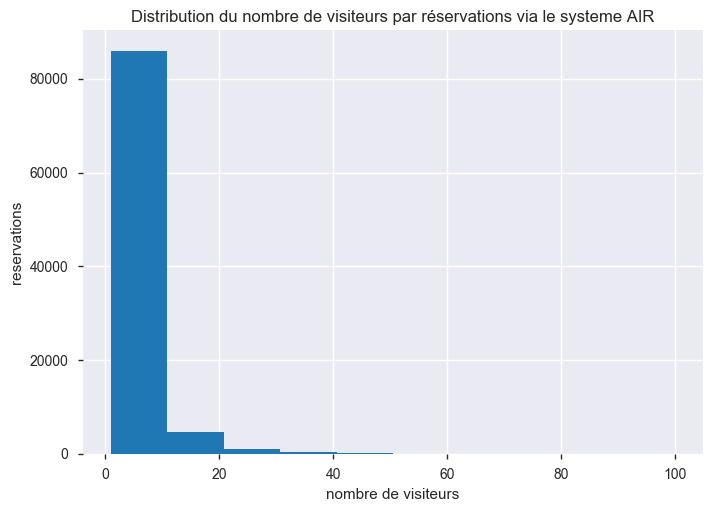

In [5]:
plot2 = plt.hist(data['ar']['reserve_visitors'])
plt.ylabel('reservations')
plt.xlabel('nombre de visiteurs')
plt.title('Distribution du nombre de visiteurs par réservations via le systeme AIR')

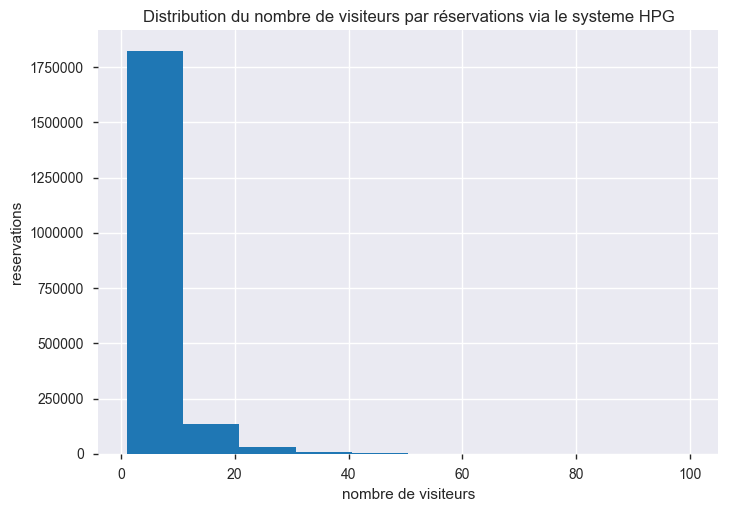

In [6]:
plot3 = plt.hist(data['hr']['reserve_visitors'])
plt.ylabel('reservations')
plt.xlabel('nombre de visiteurs')
plt.title('Distribution du nombre de visiteurs par réservations via le systeme HPG')

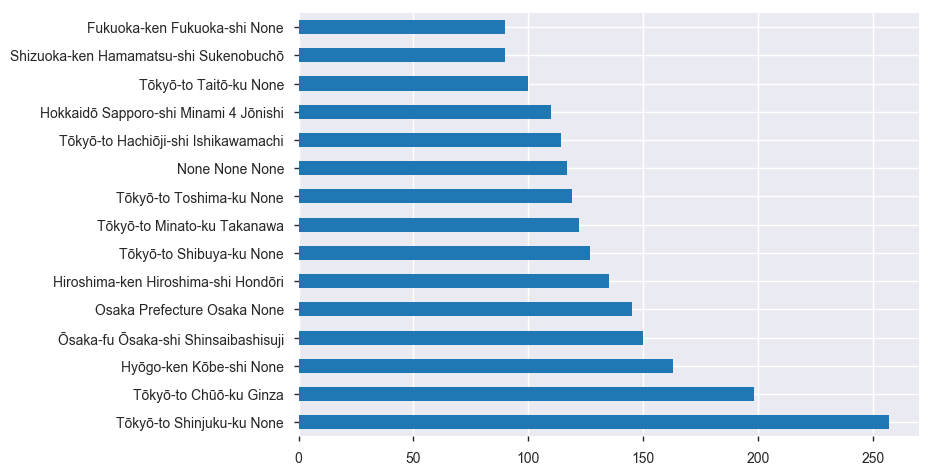

In [7]:
han = data['hs']['hpg_area_name'].value_counts().nlargest(15)
han.plot(kind = "barh")

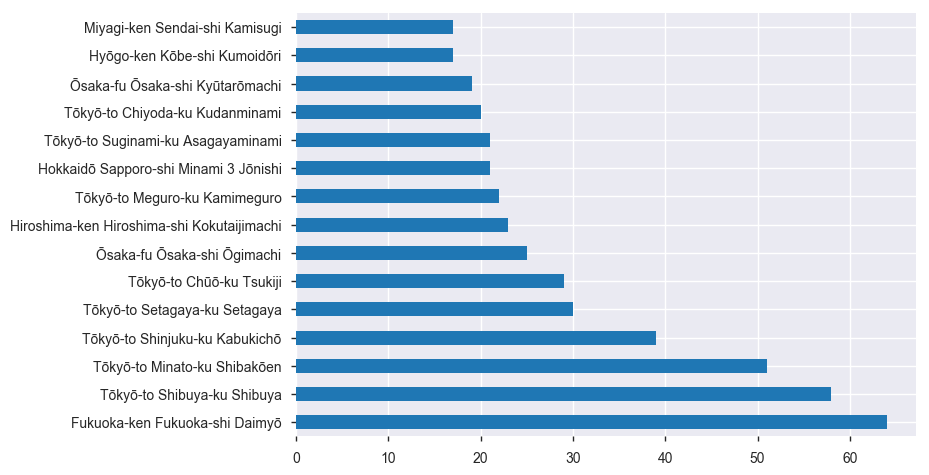

In [8]:
han = data['as']['air_area_name'].value_counts().nlargest(15)
han.plot(kind = "barh")

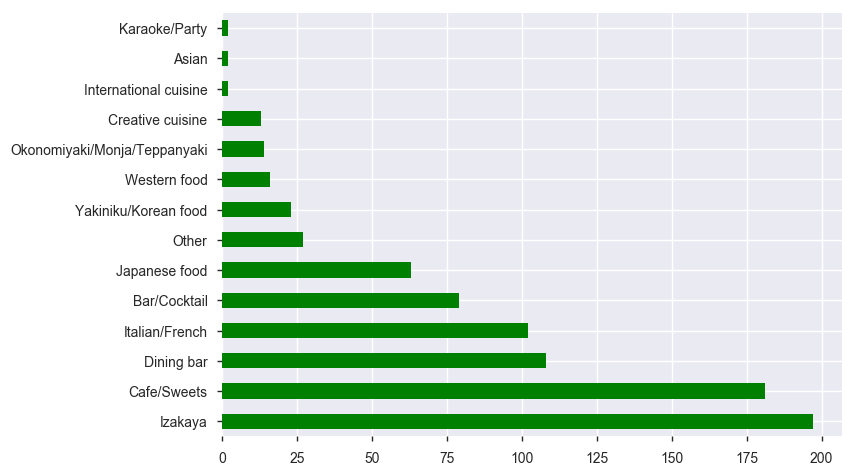

In [9]:
c = data['as']['air_genre_name'].value_counts()
c.plot(kind="barh", color = "green")

In [10]:
c1 = data['as']['air_area_name'].unique()
c2 = data['hs']['hpg_area_name'].unique()
c2 = list(c2)
c1 = list(c1)
diff_area_name = list(set(c2)-set(c1))
print(len(diff_area_name))
# 111 area_name_qui different entre AIR et HPG

111


In [11]:
#Merge between hpg and id_
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [12]:
%%time 
for df in ['ar','hr']:
    #convert to datetime + creation de "reserve_datetime_diff"

    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # Ajout de la somme (tmp1) et de la moyenne (tmp2) du nombre de visiteurs et de reserve_datetime_diff par visites    
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

CPU times: user 3.69 s, sys: 41.7 ms, total: 3.73 s
Wall time: 3.75 s


In [13]:
#convert train date into datetime
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [14]:
#convert test date into datetime
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [15]:
#Creation des unique_store dataset
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [16]:
# creation of min, mean, median, max and count visitors for every air_store_id
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

In [17]:
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
#Label encoder pour les air_genre_name and air_area_name
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [18]:
#convert date to datetime in holiday dataset
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [19]:
#creation of train and test by merging train/test and stores dataset
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 
train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

In [20]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

In [21]:
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [22]:
#Recuperation des id des store present dans le train
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

#Calcul de la somme, moyenne du nombre de visiteurs + moyenne du nombres de jours d'ecart entre reservation et visite au restaurant
train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [23]:
# NEW FEATURES 
# 
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

In [24]:
# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

In [25]:
lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

In [26]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [63]:
%%time

def get_final_parameters(best_params, origin_model_d, current_model):
    """
    Fix the string parameters returned by hyperopt.

    Use the index given by hyperopt to find the real string value
    for a specific parameter
    """
    for element_p in list(best_params.keys()):
        if isinstance(
                origin_model_d[current_model][1][element_p],
                hyperopt.pyll.base.Apply):
            if origin_model_d[current_model][1][element_p].name == "float":
                pass
            elif origin_model_d[current_model][1][element_p].name == "switch":
                apply_obj = origin_model_d[current_model][1][element_p]
                literal_obj = apply_obj.pos_args[best_params[element_p] + 1]
                best_params[element_p] = literal_obj.obj
            else:
                pass
        else:
            pass
    return best_params

def regression_params_opt(
        origin_model_d,
        current_model,
        x_train,
        x_test,
        y_train,
        y_test):
    print(current_model)
    best = 0
    global i
    i = 0
    max_eval = 100
    trials = Trials()

    def rmse_score(params):
        global i
        model_fit = origin_model_d[current_model][0](
            **params).fit(x_train, y_train)
        y_pred_train = model_fit.predict(x_test)
        loss = mean_squared_error(y_test, y_pred_train)**0.5
        df_result_hyperopt.loc[i] = np.append(loss, list(params.values()))
        i = i + 1
        return {'loss': loss, 'status': STATUS_OK}

    df_result_hyperopt = pd.DataFrame(
        columns=[
            np.append(
                'score', list(
                    origin_model_d[current_model][1].keys()))])

    best = fmin(rmse_score,
                origin_model_d[current_model][1],
                algo=tpe.suggest,
                max_evals=max_eval,
                trials=trials)
    print(best)
    print(best.keys())
    print("\n")
    return get_final_parameters(best, origin_model_d, current_model)

if __name__ == '__main__':

    xgbr_d = {'gamma': hp.quniform('gamma', 0.0, 5.0, 0.1),
              'learning_rate': hp.quniform('learning_rate', 0.1, 0.4, 0.05),
              'colsample_bytree': hp.quniform('colsample_bytree',
                                              0.3,
                                              1.,
                                              0.05),
              'max_depth': hp.choice('max_depth', list(range(5, 10))),
              'min_child_weight': hp.quniform('min_child_weight', 1., 5., 1),
              'subsample': hp.quniform('subsample', 0.6, 1, 0.05),
              'nthread': hp.choice('nthread', [-1]),
              'n_estimators': hp.choice('n_estimators', [1500]),
              'objective': hp.choice('objective', ['reg:linear']),
              'reg_lambda': hp.quniform('reg_alpha', 0.0, 4.0, 0.1),
              'reg_alpha': hp.quniform('reg_lambda', 0.0, 4.0, 0.1)}

    base_model = {"XGBRegressor": [XGBRegressor, xgbr_d]}


    x_train = train[col]
    y_train = train["visitors"]

    x_test = test[col]
    y_test = test["visitors"]

    hyper_parametres = regression_params_opt(
        origin_model_d=base_model,
        current_model="XGBRegressor",
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test
    )

df_result_hyperopt = pd.DataFrame(columns=[np.append('score', list(space4rf.keys()))])

XGBRegressor
{'colsample_bytree': 0.75, 'gamma': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 0, 'min_child_weight': 2.0, 'n_estimators': 0, 'nthread': 0, 'objective': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.8}
dict_keys(['colsample_bytree', 'gamma', 'learning_rate', 'max_depth', 'min_child_weight', 'n_estimators', 'nthread', 'objective', 'reg_alpha', 'reg_lambda', 'subsample'])


CPU times: user 1d 6h 5min 23s, sys: 2min 1s, total: 1d 6h 7min 25s
Wall time: 1d 15h 7min 3s


In [27]:
%%time
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

model3 = XGBRegressor(learning_rate=0.1, n_estimators=1500, subsample=0.8, colsample_bytree=0.75, max_depth=1, gamma = 0.6000000000000001, 
                   min_child_weight=2, objective="reg:linear", reg_alpha=0.1, reg_lambda=0.5  )
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))

RMSE XGBRegressor:  0.510622065292
CPU times: user 2min 37s, sys: 416 ms, total: 2min 38s
Wall time: 2min 38s


In [ ]:
%%time
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, max_depth =10)
model1.fit(train[col], np.log1p(train['visitors'].values))
preds1 = model1.predict(train[col])
print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))

In [28]:
%%time
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=250, subsample=0.8, colsample_bytree=0.8, max_depth =10)
model3.fit(train[col], np.log1p(train['visitors'].values))
preds3 = model3.predict(train[col])
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))

RMSE XGBRegressor:  0.438197429237
CPU times: user 4min 1s, sys: 651 ms, total: 4min 2s
Wall time: 4min 2s


In [ ]:
# To do : Hyper parametres


In [ ]:
%%time
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model2.fit(train[col], np.log1p(train['visitors'].values))
preds2 = model2.predict(train[col])
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))

In [ ]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('data/*.csv.zip')}